# First foray into LSTMs and COVID-19 forecasting

I wanted to get some practical experience with working with recurrent neural nets and LSTMs in particular. In this notebook I will use data from the [COVID19 Global Forecasting (Week 5)](https://www.kaggle.com/c/covid19-global-forecasting-week-5) Kaggle challenge and try to predict future `ConfirmedCases` and `Fatalities` numbers.

In hindsight I maybe should have picked a different problem for my first practical work with neural nets on sequential data as the time series for COVID-19 is not very long and I therefore think it is a rather hard problem and maybe a problem where more traditional methods with their strong assumptions work better than neural nets.

I started working with it after the deadline. However I started out attempting to do everything in the submission requirements. Quantile regression with `0.05, 0.50, 0.95` outputs, almost 30 days of forecast and 3463 geographical entities. In the end I realized that this made the learning experience suboptimal as it was hard to diagnose the models and I could not bring experience to the table.

In the end I therefore picked a country, `Sweden`, and focused on creating a good model for a 10 day prediciton of `ConfirmedCases` and `Fatalities` using the past 15 days as input. I also wanted to incorporate some more explanatory variables and chose [Google's COVID-19 Mobility Report](https://www.google.com/covid19/mobility/) since this is a complete and neatly prepared dataset with a clear potential for having predictive power. However I have not measured the change of performance with/without these extra variables.

After doing the work on Sweden I have tremendous respect for models that are able to do reasonable forecasts across all the 3463 geographical entities a month into the future.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from pathlib import Path
import datetime
import time
import itertools

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers as KL
from sklearn.preprocessing import MinMaxScaler

# Check GPUs:",
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Prevent TensorFlow from allocating all memory of all GPUs:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

# Setup parameters

Note: `START_DATE` is set to the start date of the Google Mobility Report dataset. I am therefore not using `ConfirmedCases` and `Fatalities` data from January and early February. This is likely not a great loss as for most countries the numbers during this early period were very sparse.

In [2]:
# Kaggle paths (uncomment to use):
df = pd.read_csv('../input/covid19-global-forecasting-week-5/train.csv')
df_mob = pd.read_csv('../input/covid19-mobility-data/Global_Mobility_Report.csv')

# Client paths (uncomment to use):
#df = pd.read_csv('data/train.csv')
#df_mob = pd.read_csv('data/Global_Mobility_Report.csv')

DAYS_IN_DF = int(len(df[df['Country_Region'] == 'Afghanistan'])/2)
START_DATE = datetime.datetime(2020,2,15) # Including
CUTOFF_DATE = datetime.datetime(2020,5,25) # Up to and including
TRAIN_TEST_SPLIT_DATE = datetime.datetime(2020,4,26) # Up to and including
DAYS = (CUTOFF_DATE - START_DATE).days + 1 # +1 because of including start and end
print(DAYS)

VARIABLES = ['ConfirmedCases', 'Fatalities']
N_FEATURES_OUT = len(VARIABLES)
# N_FEATURES_IN derived later in the notebook
df = df[df['Target'].isin(VARIABLES)]

# Set country
# Be aware that many countries are divided into sub-regions. The code only works out-of-the-box
# with smaller countries that are represented in the dataframe as a single geographical entity.
# It is however easily modified by aggregating time series
COUNTRY = 'Sweden'

N_STEPS_IN, N_STEPS_OUT = 15, 10

df

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


101


,Id,County,Province_State,Country_Region,Population,Weight,Date,Target,TargetValue
0,1,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-23,ConfirmedCases,0.0
1,2,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-23,Fatalities,0.0
2,3,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-24,ConfirmedCases,0.0
3,4,NaN,NaN,Afghanistan,27657145,0.583587,2020-01-24,Fatalities,0.0
4,5,NaN,NaN,Afghanistan,27657145,0.058359,2020-01-25,ConfirmedCases,0.0
...,...,...,...,...,...,...,...,...,...
900375,969616,NaN,NaN,Zimbabwe,14240168,0.607106,2020-05-29,Fatalities,0.0
900376,969617,NaN,NaN,Zimbabwe,14240168,0.060711,2020-05-30,ConfirmedCases,25.0
900377,969618,NaN,NaN,Zimbabwe,14240168,0.607106,2020-05-30,Fatalities,0.0
900378,969619,NaN,NaN,Zimbabwe,14240168,0.060711,2020-05-31,ConfirmedCases,4.0


# Parse Google's mobility data

The Google location data is collected from mobile devices and aggregated into the following categories. The scale used is increase/decrease from a baseline. For more details see their [documentation page](https://www.google.com/covid19/mobility/data_documentation.html?hl=en)
- Grocery & pharmacy (Mobility trends for places like grocery markets, food warehouses, farmers markets, specialty food shops, drug stores, and pharmacies.)
- Parks (Mobility trends for places like local parks, national parks, public beaches, marinas, dog parks, plazas, and public gardens.)
- Transit stations (Mobility trends for places like public transport hubs such as subway, bus, and train stations.)
- Retail & recreation (Mobility trends for places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters.)
- Residential (Mobility trends for places of residence.)
- Workplaces (Mobility trends for places of work.)

Using interpolation strategy to handle `NaN`s in order to preserve a complete time series. Actually Sweden did not have any `NaN`s so not an issue.

In [3]:
def get_country_mobility(country_name):
    df_mob_country = df_mob[(df_mob['country_region'] == COUNTRY) & (df_mob['sub_region_1'].isnull())].iloc[:,5:]
    print(df_mob_country.shape)
    if df_mob_country.isnull().values.any():
        print(df_mob_country.isnull().values.sum(), 'NaNs detected. Interpolating to get rid of them.')
        df_mob_country.interpolate(method='linear', axis=0, inplace = True)
    assert not df_mob_country.isnull().values.any() and df_mob_country.shape[0] == DAYS
    return df_mob_country.to_numpy()

data_mob_country = get_country_mobility(COUNTRY)
data_mob_country[:5,:]

(101, 6)


array([[  2.,   0.,   3.,   4.,  -2.,   0.],
       [-10.,  -7., -30., -11.,  -5.,   2.],
       [ -4.,  -3.,  -3.,  -6.,  -6.,   2.],
       [  0.,   0.,  13.,  -4.,  -5.,   1.],
       [  3.,   1.,  26.,  -3.,  -5.,   1.]])

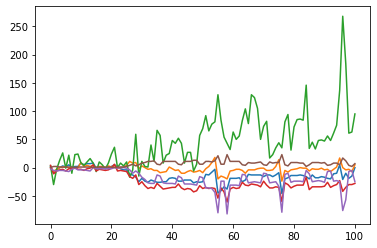

In [4]:
plt.plot(data_mob_country)

# Parsing ConfirmedCases and Fatalities

Some crunching is needed to get the data in an appropriate form. The code below does not do geography (country) selection so that one can choose to keep all geographies.

In [5]:
# Function needed to go back and forth between dates and indices in numpy arrays
def get_int_idx_from_date(df, date):
    idx = df[(df['Date'] == date.strftime('%Y-%m-%d')) & 
             (df['Country_Region'] == 'Afghanistan')].index.to_list()
    return idx[0]

print(get_int_idx_from_date(df, START_DATE), get_int_idx_from_date(df, TRAIN_TEST_SPLIT_DATE))

def df_to_npy(df, start_date, end_date, country_name = None):
    # Date slicing
    df.loc[:,'Date'] = pd.to_datetime(df['Date'])
    df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()
    # Setting negative values to 0
    df.loc[:,'TargetValue'] = np.clip(df["TargetValue"], 0, None)
    
    # From long to wide format
    df.loc[:,'new_id'] = np.repeat(np.arange(int(len(df)/2)), 2)
    df_new = df.pivot(index = 'new_id', columns = 'Target', values = 'TargetValue')
    df = df[df['Target'] == 'ConfirmedCases']
    df = df.drop(columns = ['Target', 'TargetValue'])
    df.set_index('new_id', inplace = True)
    df = df.merge(df_new, left_index = True, right_index = True)
    df_new = df
    data = df.loc[:,['ConfirmedCases', 'Fatalities']].to_numpy()
    
    l = []
    for i in range(int(len(data)/DAYS)):
        l.append(data[i*DAYS:(i+1)*DAYS, :])
    data = np.concatenate(l, axis = 1)

    return data, df_new

data, df_new = df_to_npy(df, START_DATE, CUTOFF_DATE)
print(data.shape)

def get_int_idx_from_country_region(df, data, country_region):
    days = data.shape[0]
    idx = df[df['Country_Region'] == country_region].index[0]
    idx_confirmedcases = idx / (days/2)
    assert idx_confirmedcases.is_integer()
    idx_confirmedcases = int(idx_confirmedcases)
    idx_fatalities = idx_confirmedcases + 1
    return idx_confirmedcases, idx_fatalities

# Sanity check
print(get_int_idx_from_country_region(df_new, data, 'Afghanistan'), 
      get_int_idx_from_country_region(df_new, data, 'Albania'))

46 188
(101, 6926)
(0, 1) (2, 3)


# Country selection

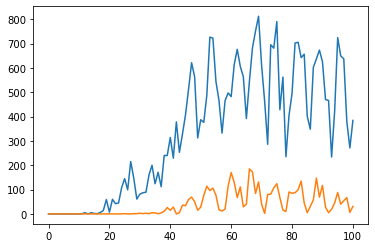

In [6]:
plt.plot(data[:,get_int_idx_from_country_region(df_new, data, 'Sweden')])

In [7]:
if COUNTRY != 'ALL':
    data = data[:,get_int_idx_from_country_region(df_new, data, COUNTRY)]
    
print(data.shape)

(101, 2)


# Combining ConfirmedCases, Fatalities and Google Mobility data

In [8]:
def combine_datasets(data_1, data_2):
    print(data_1.shape, data_2.shape)
    data = np.concatenate((data_1, data_2), axis = 1)
    print(data.shape)
    return data
data = combine_datasets(data, data_mob_country)

(101, 2) (101, 6)
(101, 8)


# Data partition and formulation into supervised problem

The biggest challenge with predicting COVID-19 numbers is the limited number of days since the outbreak of the pandemic. There is not much training data to use and we cannot afford to devote large portions to validation and test. I spent some time thinking about how to utilize the most amount of data and still get reasonable performance metrics with my validation and test sets.

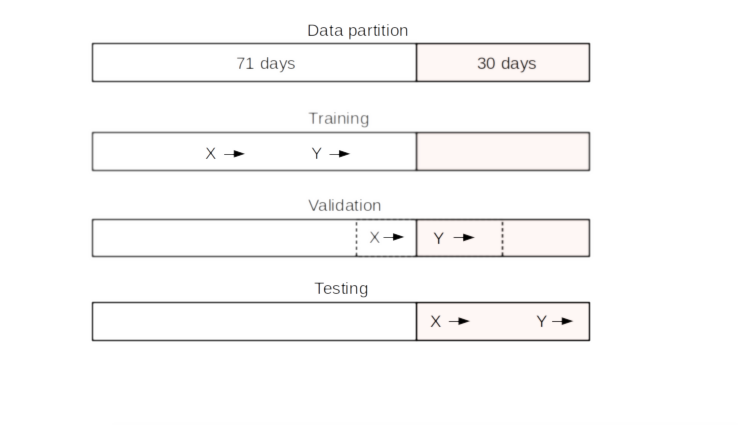

As can be seen in the image above the data is first split into what I call a `train` and a `test` partition.

For training the implementation is straight-forward. Only data in the `train` partition is used and the time series is reformulated as a supervised (`X`, `Y`) problem with a 1 step walk-forward method, using the last `N_STEPS_IN` to predict the next `N_STEPS_OUT`

For validation things get a little complicated and this is where I have made some choices I would not make if it was not for the limited amount of data. I have let `X` start where the `X` of the training set ended and let its end walk over the partition line while keeping `Y` always on the right (test) side of the line. The idea behind this is that all `X`s and `Y`s have not been trained on as `X` and `Y` in the training process.

For test things are less complicated, all `X`s and `Y`s are on the test side of the partition line.

Code adapted from implementation by Jason Brownlee at machinelearningmastery.com https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [9]:
def train_test_split(df, data, split_date):
    split_idx = get_int_idx_from_date(df, split_date)
    train = data[:split_idx,:]
    test = data[split_idx:,:]
    return train, test

train, test = train_test_split(df_new, data, TRAIN_TEST_SPLIT_DATE)
print(train.shape, test.shape)

N_FEATURES_IN = data.shape[1]

(71, 8) (30, 8)


In [10]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_train, Y_train = split_sequences(train, N_STEPS_IN, N_STEPS_OUT)
Y_train = Y_train[:,:,:N_FEATURES_OUT]
print(X_train.shape, Y_train.shape)

(47, 15, 8) (47, 10, 2)


In [11]:
def split_sequences_train_test_overlap(train, test, n_steps_in, n_steps_out):
    X_val, Y_val = list(), list()
    X_test, Y_test = list(), list()
    for i in range(len(test)):
        # find the end of this pattern
        train_start_ix = len(train) - n_steps_in + i
        #test_end_ix = i + n_steps_in
        test_out_end_ix = i + n_steps_out
        # check if we are beyond the dataset
        #print(i, train_start_ix, test_out_end_ix)
        if test_out_end_ix > len(test):
            break
        # gather input and output parts of the pattern
        seq_x = np.concatenate((train[train_start_ix:, :], test[:i, :]))
        seq_y = test[i:test_out_end_ix, :]
        #print(seq_x.shape)
        #print(seq_y.shape)
        if train_start_ix >= len(train):
            #print(train_start_ix)
            #print(train[train_start_ix:, :].shape)
            seq_x = test[i-n_steps_in:i, :]
            seq_y = test[i:test_out_end_ix, :]
            #print(seq_x.shape, seq_y.shape)
            X_test.append(seq_x)
            Y_test.append(seq_y)
        else:
            X_val.append(seq_x)
            Y_val.append(seq_y)
    return np.array(X_val), np.array(Y_val), np.array(X_test), np.array(Y_test)

X_val, Y_val, X_test, Y_test = split_sequences_train_test_overlap(train, test, N_STEPS_IN, N_STEPS_OUT)
Y_val = Y_val[:,:,:N_FEATURES_OUT]
Y_test = Y_test[:,:,:N_FEATURES_OUT]

print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(15, 15, 8) (15, 10, 2)
(6, 15, 8) (6, 10, 2)


# Scaling

Using `sklearn`'s `MinMaxScaler` to scale all 8 time series individually to a `(0,1)` range taking care to fit the scaler only using the training data.

In [12]:
X_scaler = MinMaxScaler((0,1))
Y_scaler = MinMaxScaler((0,1))
def scale(arr, x_or_y, fit = False):
    arr_shape = arr.shape
    arr = arr.reshape(-1, arr_shape[2])
    if x_or_y == 'x':
        scaler = X_scaler
    elif x_or_y == 'y':
        scaler = Y_scaler
    if fit:
        scaler.fit(arr)
    arr = scaler.transform(arr)
    arr = arr.reshape(arr_shape)
    return arr

X_train = scale(X_train, 'x', fit = True)
X_val = scale(X_val, 'x')
X_test = scale(X_test, 'x')

Y_train = scale(Y_train, 'y', fit = True)
Y_val = scale(Y_val, 'y')
Y_test = scale(Y_test, 'y')

In [13]:
def unscale(arr, x_or_y):
    arr_shape = arr.shape
    arr = arr.reshape(-1, arr_shape[2])
    if x_or_y == 'x':
        scaler = X_scaler
    elif x_or_y == 'y':
        scaler = Y_scaler
    arr = scaler.inverse_transform(arr)
    arr = arr.reshape(arr_shape)
    return arr

# CNN-LSTM model construction

The idea is that 1D Convolutions interpret the time series for the LSTM.

Not included in this notebook are other model designs (vanilla LSTM, encoder-decoder LSTM) that did not perform well compared to the CNN-LSTM approach.

Again code is inspired from implementation by Jason Brownlee at machinelearningmastery.com https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [14]:
def get_cnn_lstm_model(n_steps_in, n_features_in, n_steps_out, n_features_out, 
                       dropout = 0, conv_filter_sizes = (3,3), LSTM_size = 200, 
                       dense_size_scaler = 10):
    seq_inp = KL.Input(shape=(n_steps_in, n_features_in))
    
    x = KL.Conv1D(filters=64, kernel_size=conv_filter_sizes[0], activation='relu')(seq_inp)
    x = KL.Conv1D(filters=64, kernel_size=conv_filter_sizes[1], activation='relu')(x)
    x = KL.MaxPooling1D(pool_size=2)(x)
    x = KL.Flatten()(x)
    x = KL.RepeatVector(n_steps_out)(x)
    x = KL.LSTM(LSTM_size, activation='relu', return_sequences=True, dropout = dropout)(x)
    x = KL.Dropout(dropout)(x)
    x = KL.TimeDistributed(KL.Dense(int(n_features_out*dense_size_scaler), activation = 'relu'))(x)
    x = KL.Dropout(dropout)(x)
    x = KL.TimeDistributed(KL.Dense(n_features_out))(x)
    
    model = Model(inputs = seq_inp, outputs = x)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

get_cnn_lstm_model(N_STEPS_IN, N_FEATURES_IN, N_STEPS_OUT, N_FEATURES_OUT, 
                   dropout = 0.2, conv_filter_sizes = (3,3), LSTM_size = 200, 
                   dense_size_scaler = 10).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15, 8)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 64)            1600      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 320)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 10, 200)           416800

### History pickling

Since I am doing time-demanding tuning I need to be able to save my history dictionaries to file.

In [15]:
def save_history(hist, tag=''):
    Path('histories').mkdir(exist_ok=True)
    with open('histories/history_' + tag + '.pickle', 'wb') as dumpfile:
        pickle.dump(hist.history, dumpfile)

def load_history(tag):
    with open('histories/history_' + tag + '.pickle', 'rb') as f:
        return pickle.load(f)
    
def load_history_kaggle(tag):
    with open('../input/covid19-forecasting-models-histories/histories/history_' + tag + '.pickle', 'rb') as f:
        return pickle.load(f)

# Hyper-parameter tuning

I fitted $3^5 = 243$ models in a grid search for the best performing model on the validation set. Models and histories were saved to disk.

*Note: Maybe I could have benefited from random search instead of grid search. I forgot about its benefits.*

In [16]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

# Hyper-parameters to be tuned:
DROPOUTS = [0, 0.25, 0.5]
CONV_FILTER_SIZES = [(3,3), (5,5), (5,3)]
LSTM_SIZES = [100, 200, 300]
DENSE_SIZE_SCALER = [10, 100, 1000]

BATCH_SIZES = [8, 16, X_train.shape[0]]

EPOCHS = 500

histories = []

i = 0
for batch_size in BATCH_SIZES:
    for dropout in DROPOUTS:
        for conv_filter_size in CONV_FILTER_SIZES:
            for lstm_size in LSTM_SIZES:
                for dense_size_scaler in DENSE_SIZE_SCALER:
                    t0 = time.time()
                    folder = 'models/'
                    filename = str('sweden_cnn_lstm-' + str(i).zfill(3) + 
                                   '_bsize-' + str(batch_size) +
                                   '_drop-' + str(dropout) + 
                                   '_conv_sz-' + str(conv_filter_size) + 
                                   '_lstm_sz-' + str(lstm_size) +
                                   '_dense_sz' + str(dense_size_scaler))
                    #print('Training model', filename)
                    
                    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                        filepath = folder + filename + '_epoch-{epoch:02d}_loss-{val_loss:.5f}.h5',
                        save_weights_only=False,
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True)

                    #model = get_cnn_lstm_model(N_STEPS_IN, N_FEATURES_IN, N_STEPS_OUT, N_FEATURES_OUT, 
                    #                           dropout = dropout, conv_filter_sizes = conv_filter_size, 
                    #                           LSTM_size = lstm_size, dense_size_scaler = dense_size_scaler)
                    #history = model.fit(X_train, Y_train, 
                    #                    validation_data = (X_val, Y_val), 
                    #                    epochs=EPOCHS, batch_size = batch_size, verbose=0, 
                    #                    callbacks=[model_checkpoint_callback], 
                    #                    shuffle = True)
                    #histories.append(history)
                    #save_history(history, filename)
                    
                    t1 = time.time()
                    total = t1-t0
                    #print(str(EPOCHS), 'epochs of training finished in', 
                    #      '{0:.2f}'.format(total), 'seconds')
                    i += 1

(47, 15, 8) (47, 10, 2)
(15, 15, 8) (15, 10, 2)
(6, 15, 8) (6, 10, 2)


# Inspecting the best performing models

Since models were saved to disk with and I found it easiest to create a function that goes through the model names, extracts the validation loss, sorts and returns the `k` best performing models.

In [17]:
def plot_history(history, ylim = None, title = None):
    fig, ax = plt.subplots(1, 1, figsize = (10,5))
    ax.plot(history['loss'])
    ax.plot(history['val_loss'])
    ax.set_title(title)
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.set_ylim(ylim)
    ax.legend(['train', 'val'], loc='upper left')
    
def get_k_best_models(models_dir_path, k):
    p = Path(models_dir_path)
    l = list(p.glob('*.h5'))
    
    # Extracting the val_loss value in the file name
    names = [path.stem for path in l]
    losses = [float(loss) for loss in [path.stem[-7:] for path in l]]
    d = {}
    for i in range(len(names)):
        d[names[i]] = losses[i]
    # Sort the dict
    d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}
    # Return the lowest k val losses
    return dict(itertools.islice(d.items(), k))

#best10 = get_k_best_models('models', 10)

# Client path (uncomment to use):
#path_to_best10_pickle = 'models/best10_models_dict.pickle'

# Kaggle path (uncomment to use):
path_to_best10_pickle = '../input/covid19-forecasting-models-histories/best10_models_dict.pickle'

#with open(path_to_best10_pickle, 'wb') as f:
#    pickle.dump(best10, f)

with open(path_to_best10_pickle, 'rb') as f:
    best10 = pickle.load(f)

for name, val_loss in best10.items():
    print(name, val_loss)

sweden_cnn_lstm-054_bsize-8_drop-0.5_conv_sz-(3, 3)_lstm_sz-100_dense_sz10_epoch-343_loss-0.02011 0.02011
sweden_cnn_lstm-066_bsize-8_drop-0.5_conv_sz-(5, 5)_lstm_sz-200_dense_sz10_epoch-392_loss-0.02038 0.02038
sweden_cnn_lstm-234_bsize-47_drop-0.5_conv_sz-(5, 3)_lstm_sz-100_dense_sz10_epoch-441_loss-0.02098 0.02098
sweden_cnn_lstm-148_bsize-16_drop-0.5_conv_sz-(5, 5)_lstm_sz-200_dense_sz100_epoch-282_loss-0.02116 0.02116
sweden_cnn_lstm-148_bsize-16_drop-0.5_conv_sz-(5, 5)_lstm_sz-200_dense_sz100_epoch-281_loss-0.02137 0.02137
sweden_cnn_lstm-061_bsize-8_drop-0.5_conv_sz-(3, 3)_lstm_sz-300_dense_sz100_epoch-318_loss-0.02138 0.02138
sweden_cnn_lstm-055_bsize-8_drop-0.5_conv_sz-(3, 3)_lstm_sz-100_dense_sz100_epoch-494_loss-0.02147 0.02147
sweden_cnn_lstm-234_bsize-47_drop-0.5_conv_sz-(5, 3)_lstm_sz-100_dense_sz10_epoch-440_loss-0.02149 0.02149
sweden_cnn_lstm-124_bsize-16_drop-0.25_conv_sz-(5, 5)_lstm_sz-300_dense_sz100_epoch-130_loss-0.02150 0.0215
sweden_cnn_lstm-135_bsize-16_drop-0.

# History plots

A recurring attribute of the best performing models seem to be `dropout=0.5`. I wanted a simple regularization regime and this seems to have worked. It is especially interesting to see what is going on in model `066` and `234` (second and thirdfrom the top). Validation and training loss seem to be converging and based on a rudimentary visual analysis they could be going further if exposed to a longer trainging run.

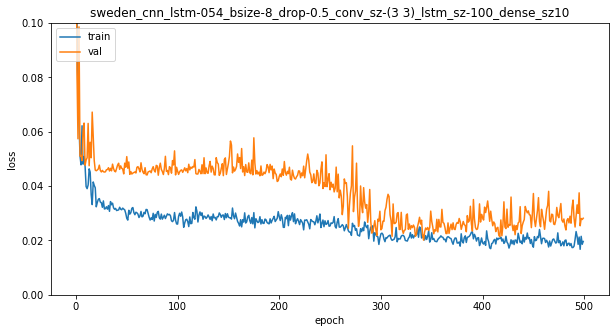

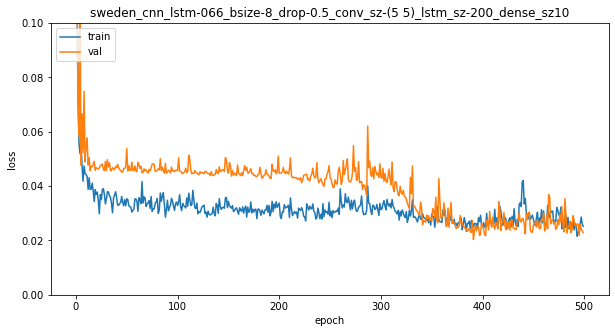

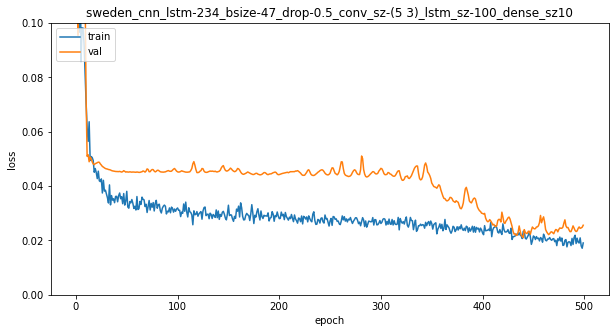

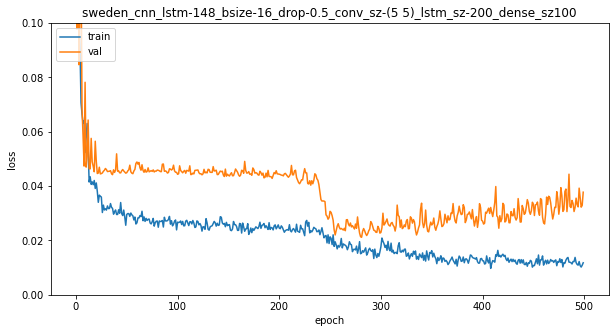

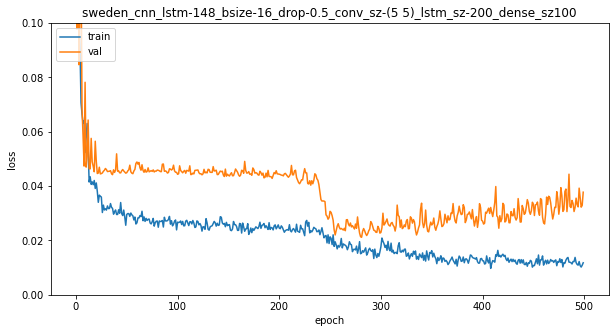

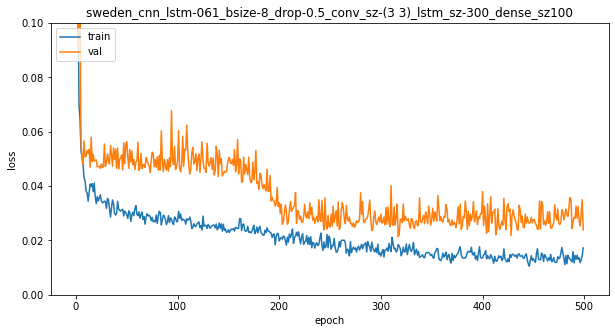

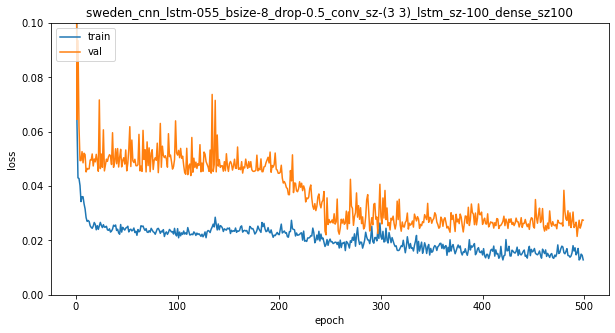

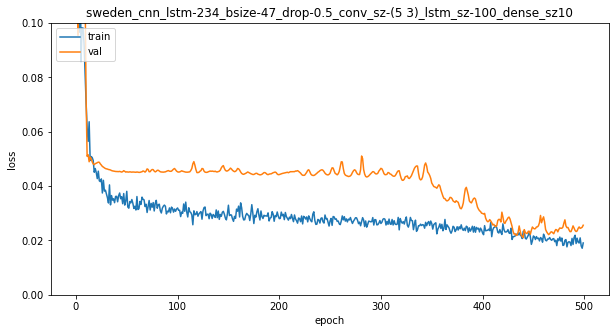

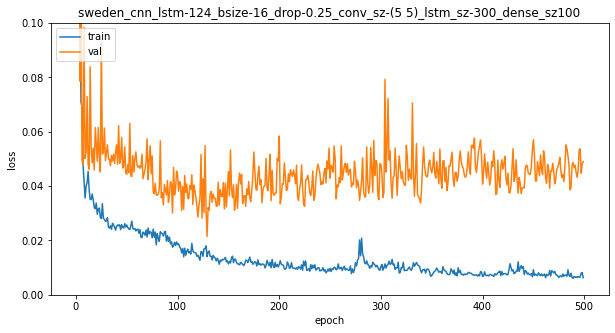

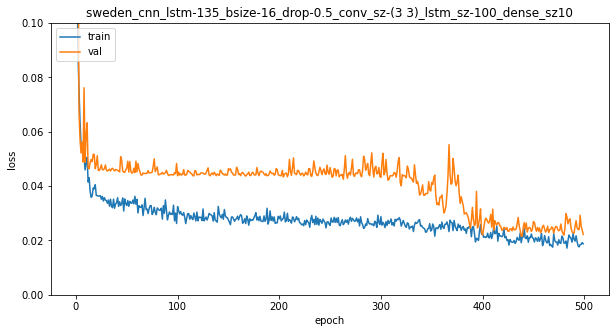

In [18]:
for name in best10.keys():
    name = name[:-23] #-23 to remove epoch and loss substrings
    name = name.replace(',', '') # Needed on Kaggle
    #history = load_history(name)
    history = load_history_kaggle(name)
    plot_history(history, ylim = (0,0.1), title = name)

 Long runs for the best 3 models

Model 054, 066 and 234 were the best 3 performing models with MSE validation loss as the metric of interest. I am running these for 3000 epochs to see if this further decrease their loss.

## Model 054 long run

In [19]:
# Model 054
EPOCHS = 3000
batch_size = 8
dropout = 0.5
conv_filter_size = (3,3)
lstm_size = 100
dense_size_scaler = 10

t0 = time.time()
folder = 'models/longruns/'
filename = str('sweden_cnn_lstm-' + '054' + 
               '_bsize-' + str(batch_size) +
               '_drop-' + str(dropout) + 
               '_conv_sz-' + str(conv_filter_size) + 
               '_lstm_sz-' + str(lstm_size) +
               '_dense_sz' + str(dense_size_scaler))
print('Training model', filename)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = folder + filename + '_epoch-{epoch:02d}_loss-{val_loss:.5f}.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model = get_cnn_lstm_model(N_STEPS_IN, N_FEATURES_IN, N_STEPS_OUT, N_FEATURES_OUT, 
                           dropout = dropout, conv_filter_sizes = conv_filter_size, 
                           LSTM_size = lstm_size, dense_size_scaler = dense_size_scaler)
model.summary()
#history = model.fit(X_train, Y_train, 
#                    validation_data = (X_val, Y_val), 
#                    epochs=EPOCHS, batch_size = batch_size, verbose=0, 
#                    callbacks=[model_checkpoint_callback], 
#                    shuffle = True)
#save_history(history, str('longrun-' + filename))

t1 = time.time()
total = t1-t0
print(str(EPOCHS), 'epochs of training finished in', 
      '{0:.2f}'.format(total), 'seconds')

Training model sweden_cnn_lstm-054_bsize-8_drop-0.5_conv_sz-(3, 3)_lstm_sz-100_dense_sz10
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 15, 8)]           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 64)            1600      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 320)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 320)           0         
___________________________________

### Model 054 long run plot

Disappointment. Model 054 did not improve with more epochs and probably due to its stochastic nature and low batch size did not find the same minimum validation loss levels as previously, this time only reaching `0.02281`

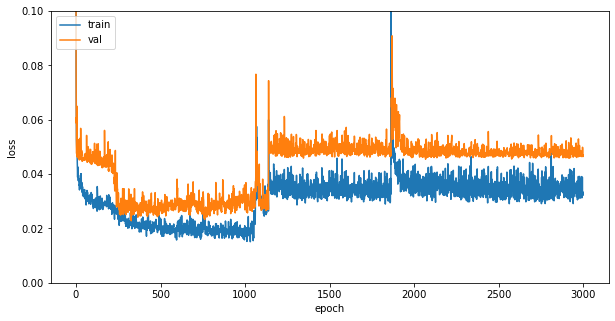

In [20]:
filename = filename.replace(',', '') # Needed on Kaggle
history_054_lr = load_history_kaggle(str('longrun-' + filename))
plot_history(history_054_lr, ylim = (0,0.1))

## Model 066 long run

In [21]:
# Model 066
EPOCHS = 3000
batch_size = 8
dropout = 0.5
conv_filter_size = (5,5)
lstm_size = 200
dense_size_scaler = 10

t0 = time.time()
folder = 'models/longruns/'
filename = str('sweden_cnn_lstm-' + '066' + 
               '_bsize-' + str(batch_size) +
               '_drop-' + str(dropout) + 
               '_conv_sz-' + str(conv_filter_size) + 
               '_lstm_sz-' + str(lstm_size) +
               '_dense_sz' + str(dense_size_scaler))
print('Training model', filename)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = folder + filename + '_epoch-{epoch:02d}_loss-{val_loss:.5f}.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model = get_cnn_lstm_model(N_STEPS_IN, N_FEATURES_IN, N_STEPS_OUT, N_FEATURES_OUT, 
                           dropout = dropout, conv_filter_sizes = conv_filter_size, 
                           LSTM_size = lstm_size, dense_size_scaler = dense_size_scaler)
model.summary()
#history = model.fit(X_train, Y_train, 
#                    validation_data = (X_val, Y_val), 
#                    epochs=EPOCHS, batch_size = batch_size, verbose=0, 
#                    callbacks=[model_checkpoint_callback], 
#                    shuffle = True)
#save_history(history, str('longrun-' + filename))

t1 = time.time()
total = t1-t0
print(str(EPOCHS), 'epochs of training finished in', 
      '{0:.2f}'.format(total), 'seconds')

Training model sweden_cnn_lstm-066_bsize-8_drop-0.5_conv_sz-(5, 5)_lstm_sz-200_dense_sz10
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 15, 8)]           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 11, 64)            2624      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 7, 64)             20544     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 192)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 10, 192)           0         
___________________________________

### Model 066 long run plot

Nice run. It achieved a new validation loss low of `0.01946` at epoch 593. Crazy stuff is happening at around 1500 epochs though. It must have jumped out of its minimum. Maybe again due to a low batch size and corresponding stochastic nature of the adam optimizer.

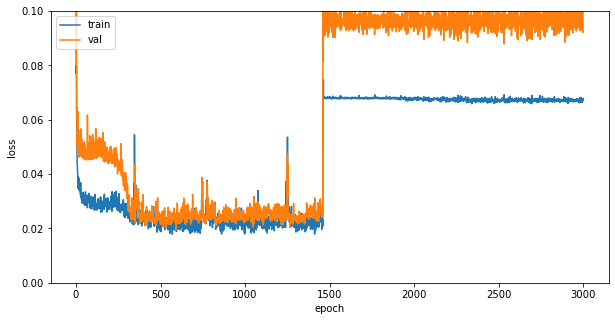

In [22]:
filename = filename.replace(',', '') # Needed on Kaggle
history_066_lr = load_history_kaggle(str('longrun-' + filename))
plot_history(history_066_lr, ylim = (0,0.1))

### Model 234 long run

In [23]:
# Model 234
EPOCHS = 3000
batch_size = 47
dropout = 0.5
conv_filter_size = (5,3)
lstm_size = 100
dense_size_scaler = 10

t0 = time.time()
folder = 'models/longruns/'
filename = str('sweden_cnn_lstm-' + '234' + 
               '_bsize-' + str(batch_size) +
               '_drop-' + str(dropout) + 
               '_conv_sz-' + str(conv_filter_size) + 
               '_lstm_sz-' + str(lstm_size) +
               '_dense_sz' + str(dense_size_scaler))
print('Training model', filename)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = folder + filename + '_epoch-{epoch:02d}_loss-{val_loss:.5f}.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model = get_cnn_lstm_model(N_STEPS_IN, N_FEATURES_IN, N_STEPS_OUT, N_FEATURES_OUT, 
                           dropout = dropout, conv_filter_sizes = conv_filter_size, 
                           LSTM_size = lstm_size, dense_size_scaler = dense_size_scaler)
model.summary()
#history = model.fit(X_train, Y_train, 
#                    validation_data = (X_val, Y_val), 
#                    epochs=EPOCHS, batch_size = batch_size, verbose=0, 
#                    callbacks=[model_checkpoint_callback], 
#                    shuffle = True)
#save_history(history, str('longrun-' + filename))

t1 = time.time()
total = t1-t0
print(str(EPOCHS), 'epochs of training finished in', 
      '{0:.2f}'.format(total), 'seconds')

Training model sweden_cnn_lstm-234_bsize-47_drop-0.5_conv_sz-(5, 3)_lstm_sz-100_dense_sz10
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 15, 8)]           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 11, 64)            2624      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 9, 64)             12352     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 10, 256)           0         
__________________________________

### Model 234 long run plot

Interesting run, but did not achieve a new low. This loss plot looks more like a traditional plot with a nice u-shaped bottom in the validation loss. This is probably caused by using a batch size of 47 (all the training data).

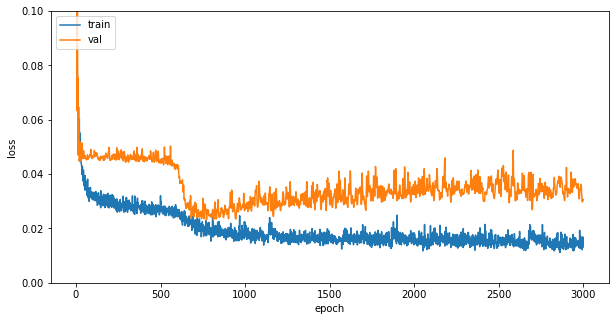

In [24]:
filename = filename.replace(',', '') # Needed on Kaggle
history_234_lr = load_history_kaggle(str('longrun-' + filename))
plot_history(history_234_lr, ylim = (0,0.1))

# Best model (066) evaluation

Much more can be done on the analysis and tuning of the best performing models, but we need to wrap things up here with a final evaluation on the test set and plots comparing predictions with ground truth.

I expect a dip on the test set evaluation. As mentioned above under the *Data partition and formulation into supervised problem* header I have made some choices with regards to the validation set that could make it somewhat dissimilar with 100% untouched, future test data. Training and test sets are also further apart in time and during the very limited-in-time pandemic this will likely cause the two partitions to be less similar.

### Loading the best performing model from disk

In [25]:
# Client path (uncomment to use):
#path_to_best_model = 'models/longruns/sweden_cnn_lstm-066_bsize-8_drop-0.5_conv_sz-(5, 5)_lstm_sz-200_dense_sz10_epoch-593_loss-0.01946.h5'

# Kaggle path (uncomment to use):
path_to_best_model = '../input/covid19-forecasting-models-histories/models/longruns/sweden_cnn_lstm-066_bsize-8_drop-0.5_conv_sz-(5 5)_lstm_sz-200_dense_sz10_epoch-593_loss-0.01946.h5'

model = load_model(path_to_best_model)
model.summary()

Model: "model_247"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_248 (InputLayer)       [(None, 15, 8)]           0         
_________________________________________________________________
conv1d_492 (Conv1D)          (None, 11, 64)            2624      
_________________________________________________________________
conv1d_493 (Conv1D)          (None, 7, 64)             20544     
_________________________________________________________________
max_pooling1d_245 (MaxPoolin (None, 3, 64)             0         
_________________________________________________________________
flatten_246 (Flatten)        (None, 192)               0         
_________________________________________________________________
repeat_vector_246 (RepeatVec (None, 10, 192)           0         
_________________________________________________________________
lstm_247 (LSTM)              (None, 10, 200)           31

### Model evaluation

When comparing to the validation loss we see a 34.9 % increase in loss. This was expected and in my opininon not too bad for this dataset.

In [26]:
test_loss = model.evaluate(X_test, Y_test)

print('{0:.3f}'.format((test_loss-0.01946)/0.01946)) #0.01946 is the validation loss of this model


6/6 [==============================] - 0s 73ms/sample - loss: 0.0263
0.349


# Model prediction on test data

Let us move through the test dataset and plot predictions for each timestep. The last plot is thus the prediction that is furthest apart in time from the training data.

I might have gotten lucky with picking Sweden as the country I tuned my models for. The country seem to have a good amount of periodicity in its reporting and I would think this was present in the 

In [27]:
Y_hat = model.predict(X_test + np.random.normal(0,0.5,X_test.shape), verbose=1)
print(Y_hat.shape)

6/6 [==============================] - 0s 32ms/sample
(6, 10, 2)


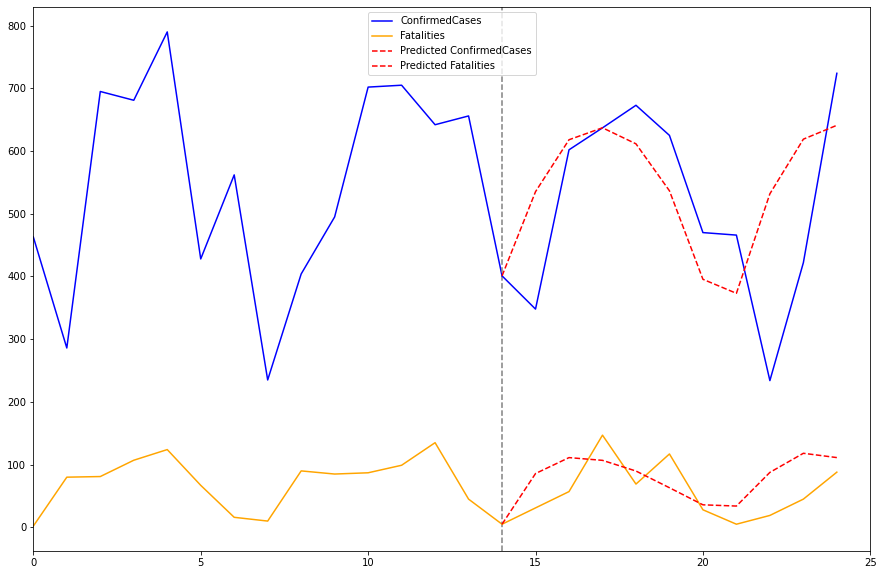

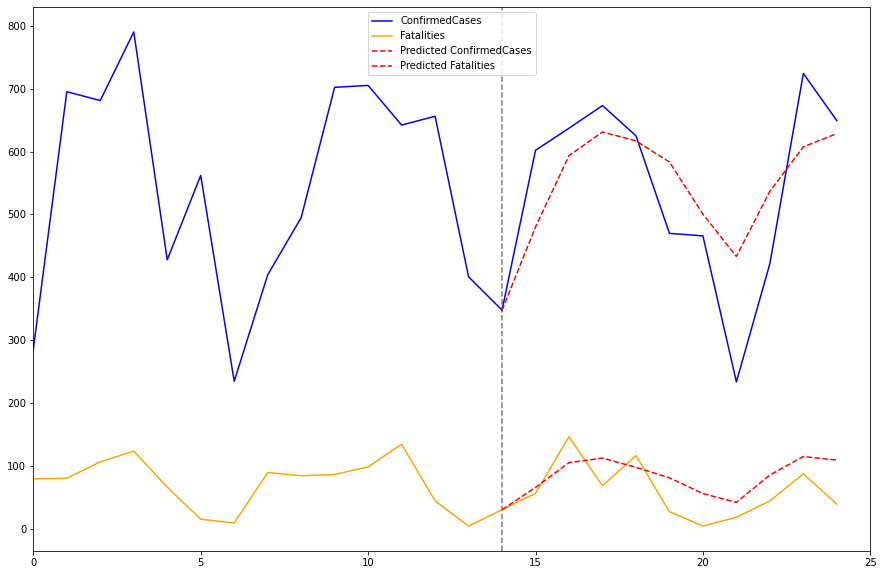

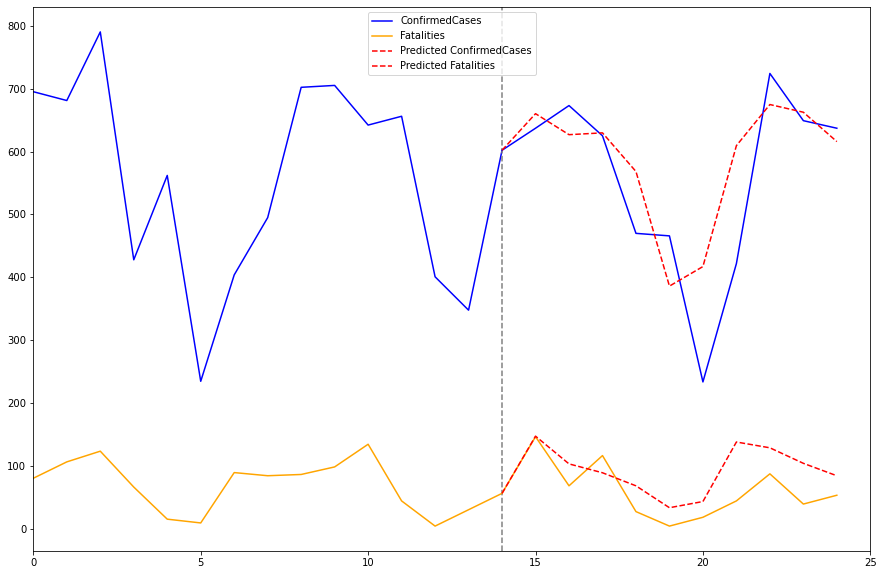

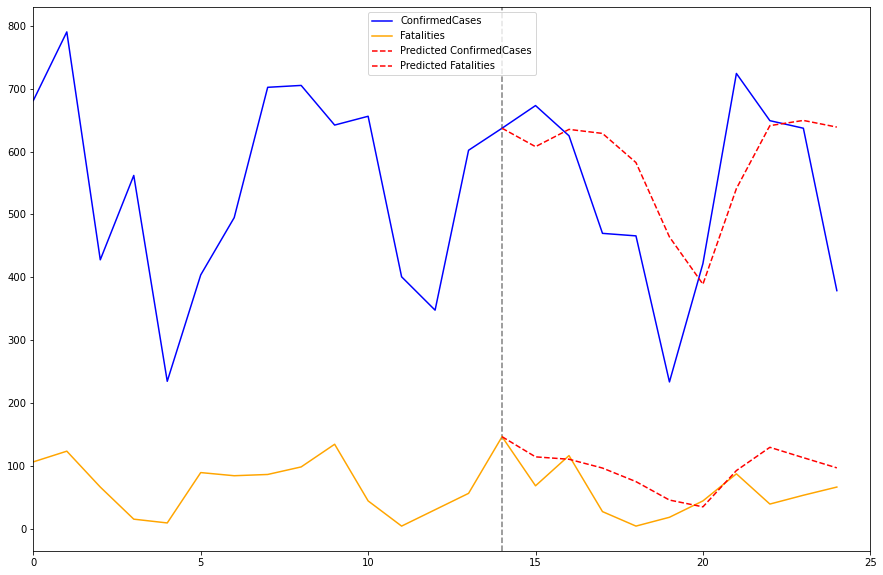

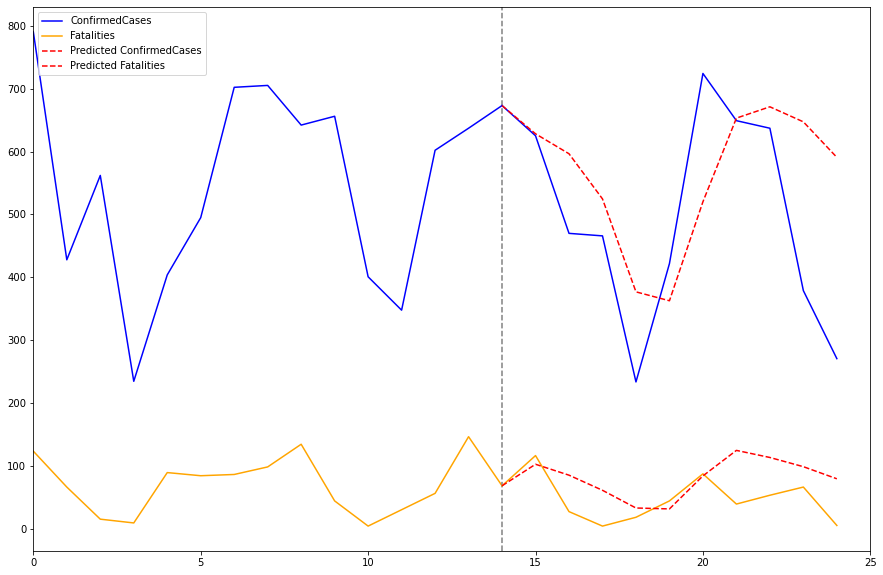

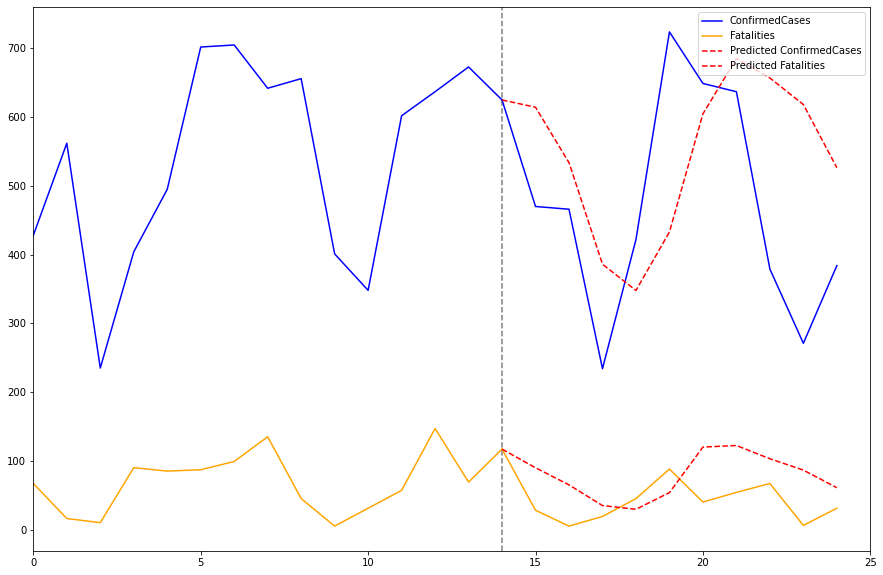

In [28]:
def plot_prediction(X_test, Y_test, Y_hat, test_idx):

    X_test = unscale(X_test, 'x')
    Y_hat = unscale(Y_hat, 'y')
    Y_test = unscale(Y_test, 'y')
    
    X_test = np.array(X_test[test_idx,:,:], copy = True)
    Y_hat = np.array(Y_hat[test_idx,:,:], copy = True)
    Y_test = np.array(Y_test[test_idx,:,:], copy = True)

    n_obs = len(X_test)
    n_pred = len(Y_hat)
    
    fig, ax = plt.subplots(1, 1, figsize = (15,10))
    
    ax.set_xlim(0, n_obs + n_pred)

    colors = ('blue', 'orange', 'red')
    ax.plot(np.arange(n_obs), X_test[:,0], label = 'ConfirmedCases', color = colors[0])
    ax.plot(np.arange(n_obs), X_test[:,1], label = 'Fatalities', color = colors[1])

    ax.axvline(x = n_obs - 1, ls = '--', color = 'grey')

    ax.plot(np.arange(n_obs - 1, n_obs + n_pred), 
                np.concatenate((np.expand_dims(X_test[-1,0], 0), Y_test[:,0])), 
                color = colors[0])
    ax.plot(np.arange(n_obs - 1, n_obs + n_pred), 
                np.concatenate((np.expand_dims(X_test[-1,1], 0), Y_test[:,1])), 
                color = colors[1])

    ax.plot(np.arange(n_obs - 1, n_obs + n_pred), 
                np.concatenate((np.expand_dims(X_test[-1,0], 0), Y_hat[:,0])), 
                color = colors[2], ls = '--', label = 'Predicted ConfirmedCases')
    ax.plot(np.arange(n_obs - 1, n_obs + n_pred), 
                np.concatenate((np.expand_dims(X_test[-1,1], 0), Y_hat[:,1])), 
                color = colors[2], ls = '--', label = 'Predicted Fatalities')
    ax.legend()
    
for i in range(Y_hat.shape[0]):
    plot_prediction(X_test, Y_test, Y_hat, i)

# Checking robustness to noise

This is in no way a statistical test, but I wanted to quickly check if the model messes up if random perturbations are made to the `X_test` data before prediction. In the below plots data left of the gray line is messed up a little while test data to the right of the line is kept as it was. The new predictions `Y_hat` based on the perturbed data are at least not shooting off to the moon or collapsing and in my opinion this is a sign of robustness of the model.

6/6 [==============================] - 0s 930us/sample
(6, 10, 2)


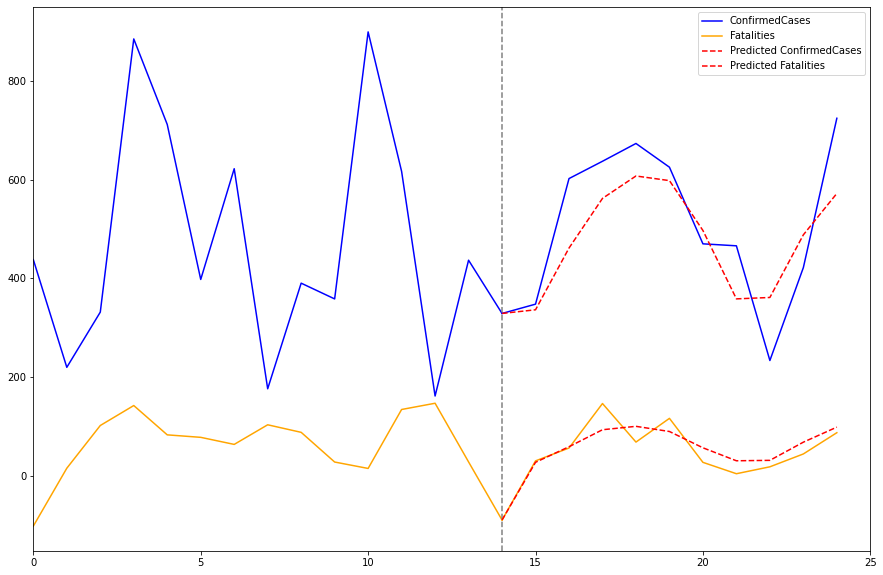

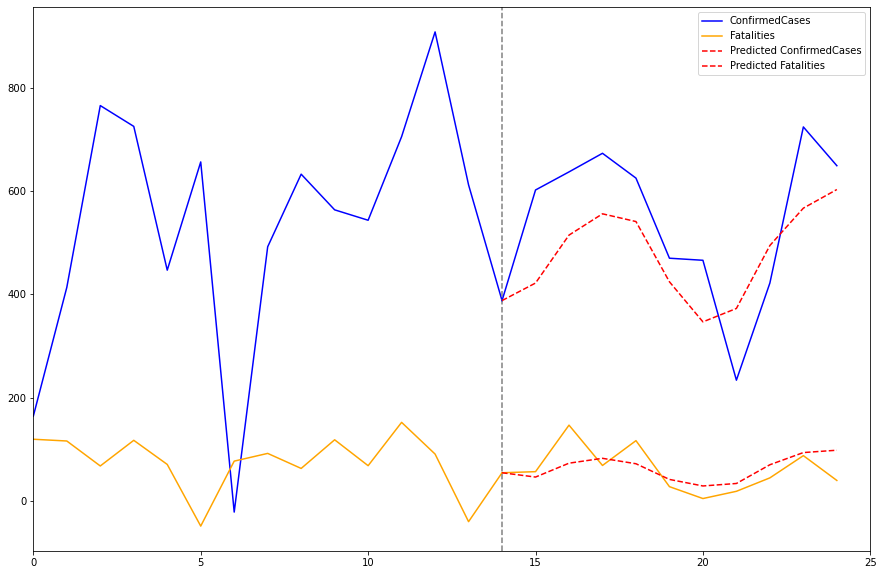

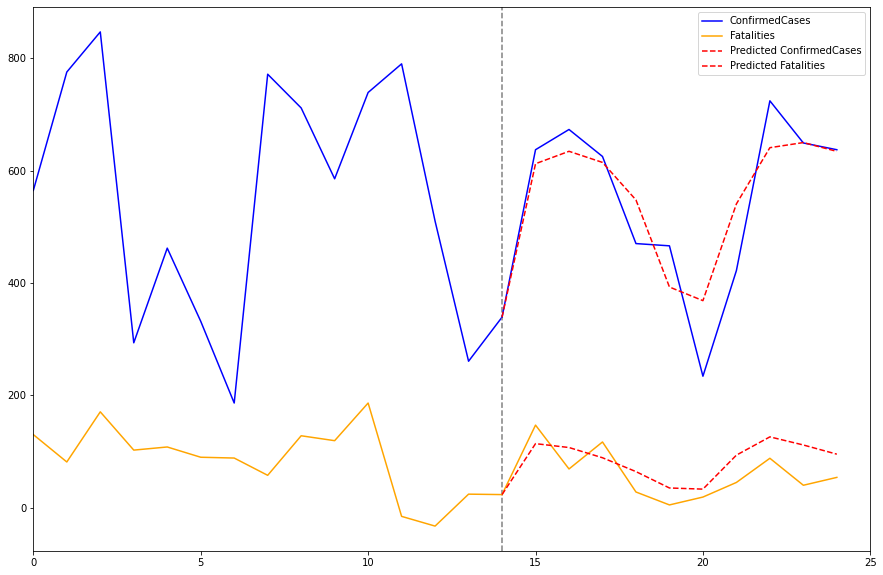

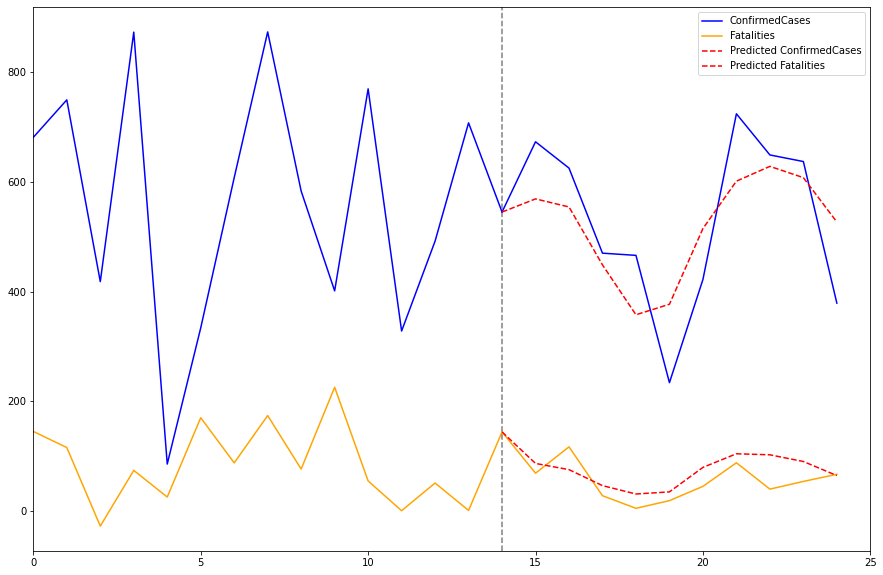

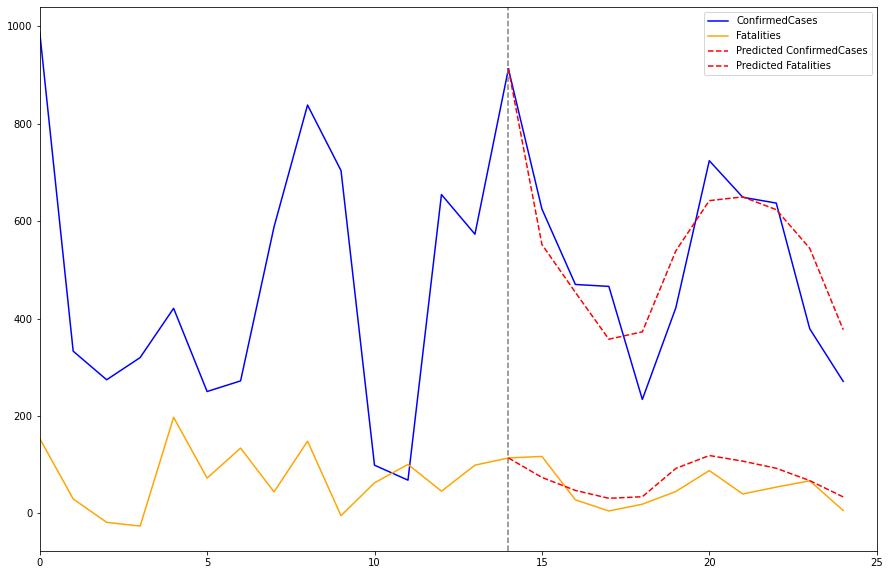

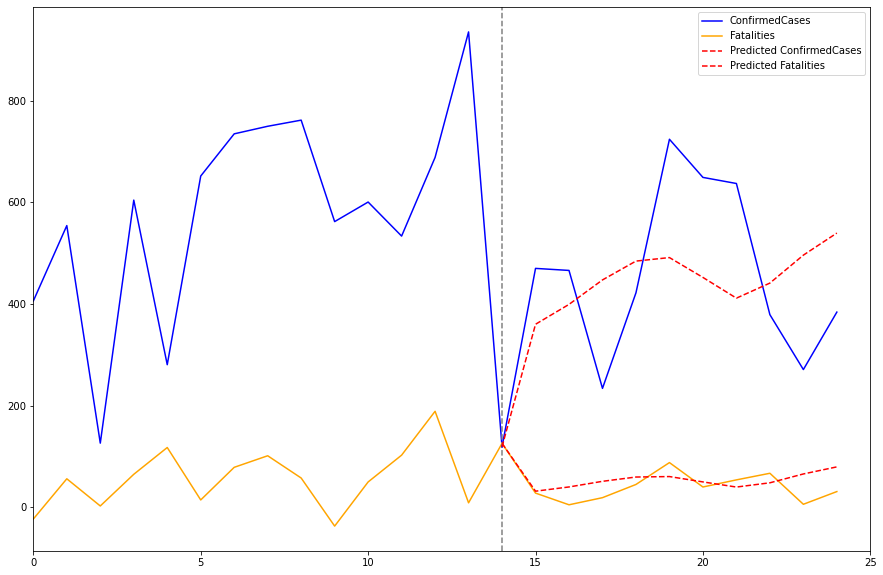

In [29]:
random_perturbs = np.random.normal(0, 0.25, X_test.shape)
Y_hat = model.predict(X_test + random_perturbs, verbose=1)
print(Y_hat.shape)
    
for i in range(Y_hat.shape[0]):
    plot_prediction(X_test + random_perturbs, Y_test, Y_hat, i)

# Ideas for future

- Quantile regression and pinball loss as specified in the challenge
- Predciting up to 30 days
- When looking at some preliminary results (before hyper-parmater tuning) for some other countries I noticed that predictions were drifting upwards. This is probably caused by the fact that the training set is non-stationary (trending upwards) while the test data is either stationary or non-stationary trending downwards. I could see if differencing the time series helps.
- Measure change in performance by inclusion/exclusion of Google Mobility Data
- Having a go at a week 6 challenge if it is launched :-)